<a href="https://colab.research.google.com/github/tazhibayda/cvision_team13/blob/main/cvisio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
cd 'drive/MyDrive/Colab Notebooks/'

/content/drive/MyDrive/Colab Notebooks


In [4]:
import time
import cv2
import os
from cv2 import resize
import numpy as np
from matplotlib import pyplot as plt
# from traceback2 import print_tb
import dlib
# !pip install traceback2
import traceback2
# from utils import rotate_bbox, rotate_bound, warpImg, findFaces, is_two_image_same
from utils import rotate_bbox, rotate_bound, warpImg, findFaces, is_two_image_same
from utils import resizeImage, get_warpPerspective, get_angle_and_box_coord


In [7]:
ls

drive/  sample_data/


Total good matches: 763
Rotation Angle: 3 degrees
Number of Faces: 1
Number of Faces: 1


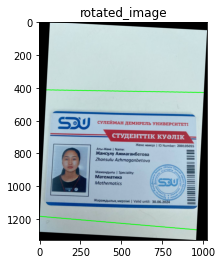

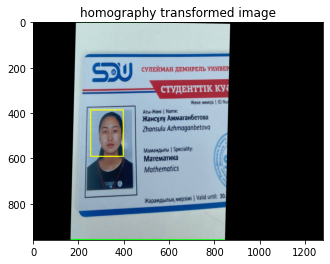

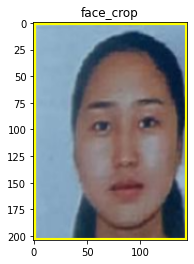

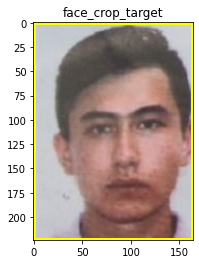

Total good matches: 6


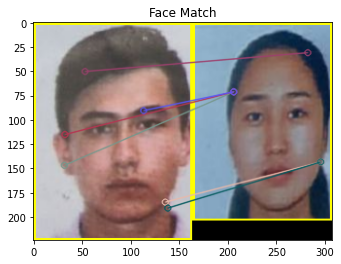

Matches are found - 6/15
Faces are not similar


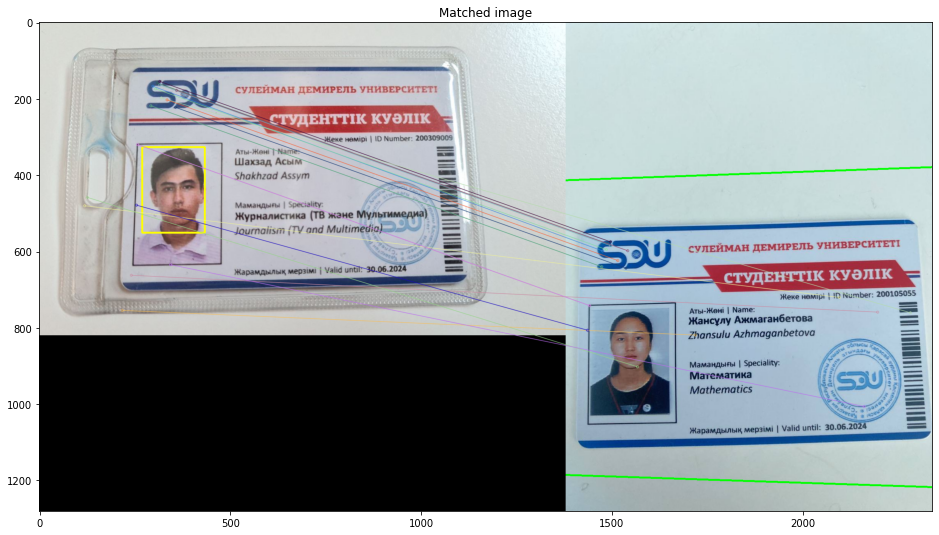

In [6]:
def siftMatching(img1, img2):
    
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)

    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)

    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append(m)
    print("Total good matches:", len(good))       
    good = good[:20]
    return kp1, kp2, good


def main():
    
    # template = cv2.imread("test/test3.jpg")
    template = cv2.imread("image/1111.jpg")
    sample = cv2.imread("image/ts.jpg")
    # template
    MIN_MATCH_COUNT = 20

    img1 = cv2.cvtColor(template, cv2.COLOR_BGR2RGB)         # trainImage
    img2 = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)           # queryImage
    img1 = resizeImage(img1)

    kp1, kp2, good = siftMatching(img1, img2)

    if len(good) >= MIN_MATCH_COUNT:

        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
        M2, mask2 = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC,5.0)
        h,w,_ = img1.shape
    
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts,M)

        border = cv2.polylines(img2, [np.int32(dst)], True, (0, 255, 0), 3)

        warped_image = get_warpPerspective(img2, M2, dst)
       
        (heigth_q, width_q) = img2.shape[:2]
        (cx, cy) = (width_q // 2, heigth_q // 2)

        angle, box = get_angle_and_box_coord(dst)
        
        rotated_img = rotate_bound(img2, angle)
        
        new_bbox = rotate_bbox(box, cx, cy, heigth_q, width_q, angle)
       
        warp_image = warpImg(rotated_img, new_bbox ,  heigth_q, width_q)
        
        face_crop_img_query = findFaces(warped_image)
        face_crop_img_target = findFaces(img1)
        
        if(img1 is not None):
            plt.title("rotated_image")
            plt.imshow(rotated_img)
            plt.show()
        
        if(warped_image  is not None):
            plt.title("homography transformed image")
            plt.imshow(warped_image)
            plt.show()
        
        if(face_crop_img_query is not None):
            plt.title("face_crop")
            plt.imshow(face_crop_img_query)
            plt.show()
        
        if(face_crop_img_target is not None and face_crop_img_query is not None):
            plt.title("face_crop_target")
            plt.imshow(face_crop_img_target)
            plt.show()
            is_two_image_same(face_crop_img_target, face_crop_img_query, 15)
        

    else:
        print("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))

    img3 = cv2.drawMatches(img1,kp1,img2,kp2,good, None,flags=2)

    fig = plt.figure(figsize=(16, 12))
    plt.title("Matched image")
    plt.imshow(img3, 'gray'),plt.show()

  

if __name__ == '__main__':
    main()

In [5]:
ls

 cvisio.ipynb               models/                                 utils.py
'Final project (1).ipynb'   __pycache__/
 image/                     shape_predictor_68_face_landmarks.dat


In [13]:
import argparse
import time
import cv2
import os


In [10]:
cd 'drive/MyDrive/Colab Notebooks/'

/content/drive/MyDrive/Colab Notebooks


In [11]:
ls

 cvisio.ipynb               models/                                 utils.py
'Final project (1).ipynb'   __pycache__/
 image/                     shape_predictor_68_face_landmarks.dat


In [4]:

mdl = "models/LapSRN_x8.pb"

modelName = mdl.split(os.path.sep)[-1].split("_")[0].lower()
modelScale = mdl.split("_x")[-1]
modelScale = int(modelScale[:modelScale.find(".")])

print("[INFO] loading super resolution model: {}".format(
	mdl))
print("[INFO] model name: {}".format(modelName))
print("[INFO] model scale: {}".format(modelScale))
sr = cv2.dnn_superres.DnnSuperResImpl_create()
sr.readModel(mdl)
sr.setModel(modelName, modelScale)

[INFO] loading super resolution model: models/LapSRN_x8.pb
[INFO] model name: lapsrn
[INFO] model scale: 8


In [1]:
img = "image/ts.jpg"
image = cv2.imread(img)
print("[INFO] w: {}, h: {}".format(image.shape[1], image.shape[0]))
# use the super resolution model to upscale the image, timing how
# long it takes
start = time.time()
upscaled = sr.upsample(image)
end = time.time()
print("[INFO] super resolution took {:.6f} seconds".format(
	end - start))
# show the spatial dimensions of the super resolution image
print("[INFO] w: {}, h: {}".format(upscaled.shape[1],
	upscaled.shape[0]))

NameError: ignored

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(upscaled)
cv2.imwrite("image/sized.jpg", upscaled)

In [ ]:
import os

# script_name = os.path.splitext(os.path.basename(__file__))[0]
# !python generate_tfrecord.py --csv_input=data/test_labels.csv --output_path=data/test.record --image_dir=images/
